### svm

利用SMO方法实现svm

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

---
#### 一些基本的辅助函数

In [2]:
def loadDataset(filename):
    dataMat=[]
    labelMat=[]
    fr=open(filename)
    for line in fr.readlines():
        #print(line)
        lineArr=line.strip().split('\t')
        dataMat.append([float(lineArr[0]),float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

X_train,y_train=loadDataset('testSet.txt')

In [3]:
# 返回在0~m样本范围内,和i不同的随机的一个值
def selectJrand(i,m):
    j=i
    while(j==i):
        j=int(np.random.uniform(0,m))
    
    return j


In [4]:
# 把alpha clip到H和L范围内
def clipAlpha(aj,H,L):
    if aj>H:
        aj=H
    elif aj<L:
        aj=L
    return aj


In [5]:
# dataSe: 是数据集
# labels: 是标签,+1和-1
# C是 alpha的最大值,约束条件
# toler 误差容忍
# maxIter: alpha不再变化的最大迭代次数,尝试这么多次的迭代alpha都不在变化后,认为找到最优的alpha.
def smo(dataSet,labels,C,toler,maxIter):
    X=np.mat(dataSet)
    y=np.mat(labels).transpose()
    b=0
    m,n=X.shape
    #alphas=np.zeros([m,1],np.float32)
    alphas = np.mat(np.zeros((m,1),np.float32))
    #print(alphas)
    iterI=0
    
    #debug
    DEBUG_SVM=False
    if DEBUG_SVM == True:
        #print("X.shape:%s,y.shape:%s"%(X.shape,y.shape))
        #print("X:%s,y:%s"%(X,y))
        print(maxIter)
        
    while(iterI<maxIter):# end
        # update
        alphaPairsChanged=0
        for i in range(m):# end
            fXi=float(np.multiply(alphas,y).T*(X*X[i,:].T))+b
            print("fXi:%s" %fXi)
            print(alphas.shape)
            print(y.shape)
            print((np.multiply(alphas,y).T).shape)
            print(X.shape)
            print(X[i,:].shape)
            
            Ei=fXi-float(y[i])
            
            if DEBUG_SVM == True:
                #print("alpha:%s",alphas)
                print("[i:%d] fXi:%s,y[%d]:%s,Ei:%s" %(i,fXi,i,y[i],Ei))

            
            # KKT conditions
            # 第一: 偏差大于 toler. y[i]表符号.
            # 第二: alphas[i]满足0~C,而且不能取边界; 这个边界问题我还没搞懂
            if ((y[i]*Ei<-toler) and alphas[i]<C ) or ((y[i]*Ei>toler)and alphas[i]>0): #kkt条件,参考<<支持向量机通俗导论>>及<<支持向量机导论>>
                j=selectJrand(i,m)
                fXj=float(np.multiply(alphas,y).T*(X*X[j,:].T))+b
                
                Ej=fXj-y[j]

                if DEBUG_SVM == True:
                    print("[j:%d] fXj:%s,y[%d]:%s,Ej:%s" %(j,fXj,j,y[j],Ej))
                
                alpha_i_old=alphas[i].copy()
                alpha_j_old=alphas[j].copy()
                if y[i]!=y[j]:
                    L=max(0,alphas[j]-alphas[i])
                    H=min(C,C+alphas[j]-alphas[i])
                else:
                    L=max(0,alphas[i]+alphas[j]-C)
                    H=min(C,alphas[j]+alphas[i]) #### 2018-08-15debug issue:   这部分的逻辑出现问题了.注意同号时候要相加.
                if L==H: #### 2018-08-15debug issue:   这部分丢掉了L和H相等的时候,是alphas[i]和alphas[j]同为0时,此时后面没必要再去计算,更新量都为0.
                    print("L==H")
                    continue
                eta=2.0*X[i,:]*X[j,:].T - X[i,:]*X[i,:].T - X[j,:]*X[j,:].T
                if DEBUG_SVM == True:
                    print("eta:%s"%eta)
                    print("i:%d,X[i,:]:%s" %(i,X[i,:]))
                    print("j:%d,X[j,:]:%s" %(j,X[j,:]))
                    print("X[%d,:]*X[%d,:].T:%s"%(i,j,X[i,:]*X[j,:].T ))
                    print("X[%d,:]*X[%d,:].T:%s"%(i,i,X[i,:]*X[i,:].T ))
                    print("X[%d,:]*X[%d,:].T:%s"%(j,j,X[j,:]*X[j,:].T ))
                    
                if eta>=0:
                    print("eta >=0")
                    continue
                alphas[j]-=y[j]*(Ei-Ej)/eta # 更新alpha[j]
                alphas[j]=clipAlpha(alphas[j],H,L)
                if DEBUG_SVM == True:
                    print("Ei-Ej:%s"%(Ei-Ej))
                    print("L:%s,H:%s"%(L,H))
                    print("(Ei-Ej)/eta:%s" %((Ei-Ej)/eta))
                    print("alphas[%d]:%d"%(j,alphas[j]))

                if(np.abs(alphas[j]-alpha_j_old)<0.00001):
                    print("j not move")
                    continue
                alphas[i]+=y[j]*y[i]*(alpha_j_old-alphas[j])
                
                b1=b-Ei-y[i]*(alphas[i]-alpha_i_old)*X[i,:]*X[i,:].T-y[j]*(alphas[j]-alpha_j_old)*X[j,:]*X[j,:].T
                b2=b-Ej-y[i]*(alphas[i]-alpha_i_old)*X[i,:]*X[i,:].T-y[j]*(alphas[j]-alpha_j_old)*X[j,:]*X[j,:].T
                if (0<alphas[i]) and (C>alphas[i]):
                    b=b1
                elif (0<alphas[j]) and (C>alphas[j]):
                    b=b2
                else:
                    b=(b1+b2)/2.0
                    
                alphaPairsChanged+=1
                print("iter: %d i:%d, pairs changed %d" % (iterI,i,alphaPairsChanged))
        #if DEBUG_SVM==True:
        #    break
            
        if alphaPairsChanged==0:
            iterI+=1
        else:
            iterI=0
        print("iteration num: %d"%iterI)
    
    return b,alphas
                
                
            
        # break
    
b,alphas=smo(X_train,y_train,0.6,0.001,40)    

fXi:0.0
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:0.0
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:1, pairs changed 1
fXi:[[-2.26318494]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:2, pairs changed 2
fXi:[[-1.08640347]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.91671469]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.69509159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.03928798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02893629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.66155202]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:8, pairs changed 3
fXi:[[-3.43266857]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18530223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.55673085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.93201153]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.13220103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.71837228

fXi:[[ 1.24885502]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.62684769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.2551362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.41140095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.21978717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51447896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.73518536]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.3959407]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.64602618]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.28875108]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.6693641]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.09433246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.13926042]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19341571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.71065506]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.64661189]]
(100, 1)
(100, 1)
(1, 100)


(100, 2)
(1, 2)
j not move
fXi:[[ 2.54848166]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.85999379]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.01172416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.66840478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-0.72621945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.20806334]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.67016529]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.73143392]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.39406231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-0.39650303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.36777348]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53725336]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.67138868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 0 i:69, pairs changed 4
fXi:[[-0.74998689]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j

fXi:[[-1.49385596]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.61434375]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.13937072]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81524521]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.77923593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54353943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55427313]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.51180342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.11373732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.86811463]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[ 1.30194665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.56895729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.66016611]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.52477699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.2300381]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.81933592]]
(100, 1)
(100, 1)
(1, 100)
(100

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-4.05680727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.37522815]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.26329322]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.96698948]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-2.33214896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.70521814]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.74752592]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.56227737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-3.03876679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.96468024]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27078979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.60680239]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.95947304]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.69384376]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.5

(1, 2)
fXi:[[-1.86733901]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-3.1001102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.44021948]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.85140965]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25413511]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.90709029]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57372085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.89762048]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.77488472]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95076843]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44928989]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.59562103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.44513288]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.2309955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.1429462]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not m

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.7562765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92997007]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55464557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74957869]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.41449579]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.24287725]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66594667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.66736765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24316804]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08957401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.74092416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.54767424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55476688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5207631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24873416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi

fXi:[[ 3.52842297]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.71474644]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55655324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09421278]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.06788014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.44498562]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.0805564]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.01251179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99600056]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.73450172]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:[[-1.00734292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.48916182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50679617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.60943023]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33885519]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.07869175

(1, 2)
fXi:[[ 2.34916668]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80024557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.6888479]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 2 i:17, pairs changed 1
fXi:[[ 1.90963321]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63854013]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00938641]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91049762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.95178256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.05314112]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.4250193]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.75768588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.58413082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.69938823]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.46004213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.00232021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not mov

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.44512024]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31850102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.55028614]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.8949469]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.42604179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.82699883]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.47776731]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14552555]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47452176]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22112484]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52138686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02161783]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03392904]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.88886338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.80306585]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2

(1, 2)
fXi:[[-2.20075999]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34496371]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.7906175]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97153739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.0783473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24303887]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.0472512]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.38433395]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16616655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09357129]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25700011]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14568966]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10859227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.66480408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.09800967]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98555237]]
(100, 1)
(100, 1)
(1

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30246015]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.1558333]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36872826]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.18857241]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42072585]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4088667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.78495657]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.42641505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.34602457]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33022628]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07822974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 4
fXi:[[-1.35857207]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84229226]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.16403318]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94108376]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98226024]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.10149549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5498253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.89935818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.96662473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.61656107]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00510535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.8967306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.97475772]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.05750075]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.34286105]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.76265428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.60104753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.70221416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-3.46069045]]
(100, 1)
(100, 1)
(1, 100)
(100

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.0787714]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43878207]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2615635]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.56981608]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.77370703]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42889637]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.81914835]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.47729143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16692087]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45319665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21704401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57654554]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.03032547]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.06079062]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.89685467]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.750

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79061765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97153751]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.07834681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24303838]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.04725081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.38433394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16616607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.0935707]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2570002]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14568974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10859172]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.6648042]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.09800917]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98555194]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.79068078]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.7836

(1, 2)
fXi:[[ 3.15583319]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36872809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.18857232]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42072588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40886672]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.78495658]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.42641506]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.34602455]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.33022641]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07822989]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 17
fXi:[[-1.35857231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84229244]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.16403253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94108393]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.97390602]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37893034]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.54137733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.65474509]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.22282291]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.53485411]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43393174]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.72013224]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.49994838]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.95129631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.52168431]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.32775137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19682466]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.09423801]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.45383415]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 1 i:29, pairs changed 1
fXi:[[-1.3132143]]
(100, 1)
(100, 1)
(1, 

(100, 2)
(1, 2)
fXi:[[ 2.66412311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.04755133]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.66600117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33716799]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75467459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25581079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68012739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22663424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.94921705]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.88459485]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.03628521]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.81923146]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.18412788]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98330974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.72429287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30334525]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10934905]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.4330225]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.58102045]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2021651]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.31470667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.96710287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.02107065]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63163279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.96212338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.93856702]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95592055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06888142]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16129221]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09113466]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.83408546]]
(10

(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88242683]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57505505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88730288]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25866634]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09028557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41730214]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.80027003]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.20844033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.97638941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.21173527]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.6777283]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07236682]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46419839]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88378723]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.421101]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.93677109]]
(1

fXi:[[-2.04273944]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38699524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07794115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.10287749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.90693865]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.27140664]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98730333]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.37532012]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-3.18274458]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.39563771]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.87658869]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29693809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2667387]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08870309]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25838334]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76597294]]
(100, 1)
(100, 1)
(1, 100

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16660844]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.59827029]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4624308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.78391417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00803369]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62760918]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98494401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.61028147]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32666573]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67961951]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35796357]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.72989713]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1937351]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.08431624]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.00150684]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j n

fXi:[[-2.44247355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20487324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 1
fXi:[[-1.44531693]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98450083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4589979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00441001]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1586231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.97658955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32215522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91559452]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.31380436]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-3.10123226]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32553797]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79892227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20628632]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34348656]]
(100, 1)


(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.77870473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.42095631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3305572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08945491]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.20638663]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76013869]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24316553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.18193777]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02328148]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17651082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30351541]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20449225]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.90222088]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51915866]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.61438076]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75726802]]


(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.28458279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.0384683]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47486838]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00995505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.34340892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-3.28091495]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.39088058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91334744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.38956557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39011536]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14293259]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43527941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.94969901]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.97469345]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.27345557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.

(100, 2)
(1, 2)
fXi:[[ 3.04692701]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86461516]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24880753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02928713]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53550525]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16226526]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31187641]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38351432]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66391293]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48577891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.92476418]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96410645]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.81038078]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.129295]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.74185995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50809819]]
(100, 1)
(100, 1)
(1,

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.73715211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02710209]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49083276]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.79075769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01391909]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22575265]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48298899]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67377541]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.28405817]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.71371773]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58431419]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.66401296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.55781753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43008408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.67831469]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.87148743]]
(100, 1)
(

fXi:[[-2.15052652]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63791414]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86085222]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76361083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.25331572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.56483004]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 1 i:17, pairs changed 1
fXi:[[ 2.16826099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.98613877]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28226359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16665681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.20210628]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.20504767]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.59025763]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.97544406]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.78414145]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi

fXi:[[-2.1371292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28456434]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40652218]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.3118138]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.83465563]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63140788]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.51764073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68848719]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4205379]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.75312987]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.63234579]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06108483]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.66606302]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.53940112]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.67077753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40809302]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.44022915]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36736899]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.14948094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.96011296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32279268]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10690103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61916708]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24496818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39971785]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46298725]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.76433146]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.579447]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.07017723]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03870886]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.90434617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.01255207]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.17249802]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33202651]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.73619736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.04217394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49872299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.8134015]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02216053]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22180631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48729272]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6838472]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.28901665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.64376706]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59506253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.66314862]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.55256482]]
(10

fXi:[[-2.30401557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20664095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15682049]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54035673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.85954346]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00446638]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.71666363]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66546424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.50158336]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94850676]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.53859088]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40180629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58244302]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31195293]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 1
fXi:[[-1.47500327]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06036092]]
(100, 1)
(100, 1)


fXi:[[-2.21768008]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66732359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.19305997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.88137275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.51548984]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.95988897]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2362953]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10415602]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51470631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.10911639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.42269861]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.2562647]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.06726023]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.87734393]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.97332688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02652515]]
(100

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.96241216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06820861]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.99812375]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30254949]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.89362775]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66649818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06069636]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41903091]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09614462]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52524993]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02744844]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.02871196]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.120203]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.99188044]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 1 i:55, pairs changed 1
fXi:[[-2.22083476]]
(100, 1)
(100,

fXi:[[-3.90078989]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02089201]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.38127818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.42662167]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.21295916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09460214]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41122835]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07385383]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77077606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16723518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34401213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46518894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70058606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.567349]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.9839765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09124831]]
(100, 1)
(100, 1

fXi:[[ 2.2329486]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.39450628]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.94459507]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32565984]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.34248253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06296327]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2081591]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32796038]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23540089]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12295612]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57110005]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.792771]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97066612]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65268869]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.68987242]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.54190077]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1,

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.38500236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-3.33510871]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.39639532]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91248531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35552053]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61450342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14044097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58330966]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.14314122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.04773882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.39019543]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.93877446]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20089903]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08530983]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44066731]]
(100, 1)
(100, 1)
(1, 100)
(100, 

(100, 2)
(1, 2)
fXi:[[ 2.77077531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.1672354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34401227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46518862]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.7005862]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.56734901]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.98397662]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09124817]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.99016646]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.293558]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.88350276]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65713873]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.05379878]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43829516]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.08638008]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51608471]]
(100, 1)
(100, 1)
(1, 1

(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98634652]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15986224]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55000464]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.7589257]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.35313192]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.44031242]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67159151]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.71478081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48782006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31637726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.81104836]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.74412091]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54289879]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5374291]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2329487]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.39450639]]
(100, 1)
(100

fXi:[[ 2.48726356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03570827]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.47169819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25970465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.05622874]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79336824]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.85755847]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.97612585]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.33662166]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47363216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.26030014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13921541]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4571385]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02865928]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.81454829]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12376887]]
(100, 1)
(100, 1)
(1, 100

fXi:[[-2.57206917]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31240138]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 3
fXi:[[-1.48230014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07156156]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.78463377]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09331982]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45636119]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25742101]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6350816]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99625546]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.33857315]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-3.29201099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35139625]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86874686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31394545]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65839493]]
(100, 1)

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29983229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51435579]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65692821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52167795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.94195514]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04286557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.03653452]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3391661]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.92918962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70405359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09926849]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39459293]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13480828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56244099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99942111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00326721]]
(100, 1)
(1

fXi:[[-2.65692813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52167773]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.94195527]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04286513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.0365352]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33916669]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.92919017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70405429]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09926912]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39459283]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13480911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56244164]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99942094]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0032671]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.1537702]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.02511692]]
(100, 1)
(100, 1)
(1, 100)


(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.39029297]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01793762]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16373165]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28404894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19105572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.16798721]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52659229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.84076791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.01568494]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70038691]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.64593517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.49649428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94339734]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.53952828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.38735561]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.572

(100, 2)
(1, 2)
fXi:[[ 2.56481092]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20957118]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67498]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.20066763]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.87338744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.52316037]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.95171125]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22818464]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09605759]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52237686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.10111017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41466321]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.26395916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.07497222]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86926653]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.96505531]]
(100, 1)
(1

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02821562]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09132885]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36054312]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.94506912]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76739099]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13104292]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51248391]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.24689203]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60810921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.10465542]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.12112061]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.09105278]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.03286498]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.27404221]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.06729423]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.56151613]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41503844]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.91904392]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.83194383]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67431601]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57585112]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.31813271]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.51624541]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.03732396]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48414928]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.49046877]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0932077]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.25781315]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39425607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28785971]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.18921616]]
(1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18609114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52789724]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2628927]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.73235098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07904978]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.36342951]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.4428522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41499287]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97589399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48760644]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63948245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22234832]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68924921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.24063808]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96713501]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.516

fXi:[[ 2.68924921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.24063808]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96713501]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.51608293]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.00431174]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.259872]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13241229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53798803]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.11285063]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4880806]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.28833442]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08899672]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.89169554]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.01530712]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03901058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.40915724]]
(100, 1)
(100, 1

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47426487]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.05713244]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.8547226]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.24768538]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.36093356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30366247]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70672356]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.94291186]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.96407067]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.25124904]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.13827]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.17065465]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24822488]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.88384508]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.05727408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
f

fXi:[[-2.59164449]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.80012114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0096425]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59414187]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42455502]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.20764218]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.41468322]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92093111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4282711]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.40985927]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22158231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39866778]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5458879]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.430415]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.04962732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.76359749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 

fXi:[[ 2.44035614]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.12621546]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66223329]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21377248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4632517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.60969331]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.54538883]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13213408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.68916531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47662704]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.3890126]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58890182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12463746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02728916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.43418028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.14533796]]
(100, 1)
(100, 1)
(1, 100)

fXi:[[ 2.36964956]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22430166]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62962495]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40447374]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54895039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58515836]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.93712404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70238451]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.32229796]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08469849]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98064605]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.23512183]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.82222837]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66913459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00100018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66834908]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)

fXi:[[-1.02401746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.45023787]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33753204]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.13261568]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79610683]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.90003118]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.96018085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.32743591]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56223058]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.36425701]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.22295588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53812272]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02745733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.88725079]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13568326]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30993217]]
(100, 1)
(100, 1)
(1, 10

fXi:[[-1.37780338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.8205656]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41146821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.28361357]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.45120347]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17785551]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 0
fXi:[[-1.34531137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92326412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.84930348]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98349648]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56546306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33333933]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75503075]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.88279676]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.20593362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.19033538]]
(100, 1)
(100, 1)
(

(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.33154516]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34863995]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.15167605]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.69283746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.74816814]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.87238021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.23091885]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5767987]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.36058139]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.1992899]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54376084]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.90783265]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86511288]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02823181]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19169069]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 

(1, 2)
iter: 6 i:52, pairs changed 1
fXi:[[-1.91820263]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.1786387]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.06561283]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.12129031]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14039912]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.80423784]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.97186723]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17028391]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.53702303]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.19177571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31768618]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.96369328]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84895598]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02555185]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61243812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 

fXi:[[-2.19135685]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09800257]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.16328636]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42641621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.83784]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.01379746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.71751573]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54629021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41136789]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84995264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.45071974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.30873717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46942509]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20942391]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 3
fXi:[[-1.3915185]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96793333]]
(100, 1)
(100, 1)
(1, 

(100, 2)
(1, 2)
fXi:[[-1.94653315]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.54635227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40670974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.56684794]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30517855]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 3
fXi:[[-1.48617666]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06203163]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68773424]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09977669]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38309025]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17299543]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56379503]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00259062]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.34639386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.28439802]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.36817941]]
(1

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.18076213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98302039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.80814795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.83840878]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.00148978]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.35588635]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39759343]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.17153895]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.03518512]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37432964]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03139831]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.71123388]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13583498]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30398301]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45142606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65769761]]

(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.93534258]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.28592284]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.99527166]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.99432908]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.16103142]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33798174]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.72126775]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.07258101]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49348986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.85210974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0173123]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20359695]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50589507]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70877299]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.30833648]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18260117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30641783]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21045502]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.1352269]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54359517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.82818584]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98335917]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68948888]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6668545]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51024512]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95577507]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.54866353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40840772]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58640915]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31949939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 1
fXi:[[

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58500126]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15205139]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.05299781]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.38091714]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.88147655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.1428934]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03259025]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44588063]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02893798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.50136604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22909143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02201729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.7797377]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.82429403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.97686584]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.3

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33300156]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.92975627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75687262]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.08098345]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4558888]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.25587616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58994189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.09423135]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.08012021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.04752427]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.04752421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.17362572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.977603]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.97082727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.12410111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.86143117]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81257434]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68363226]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51800824]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30616402]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.48499985]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00278537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52163741]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.4802886]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01956175]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19250921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33628919]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22351459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12847432]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54891153]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.9362

(100, 2)
(1, 2)
fXi:[[-2.22351459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12847432]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54891153]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.9362489]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97671344]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.79016251]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6942963]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.48398409]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92868922]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.49893271]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41869041]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57847868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27010379]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 9
fXi:[[-1.41259506]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98078449]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.73148617]]
(100

(1, 2)
fXi:[[-1.01235528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.35265975]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.07138417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35457461]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22367422]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35188357]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.23796366]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.54860588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.095865]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.90863256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99898862]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.07532051]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.15614677]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.51749517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35790757]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15072172]]
(100, 1)

(100, 2)
(1, 2)
fXi:[[ 2.58106704]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.90368518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.60768665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07777236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41490512]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.25230039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.23364868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.87959124]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.87959114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.32672359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.80538645]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.12025354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.27282148]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39093679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.83397102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.50816398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34330279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.13243421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30584083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.82584723]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34691518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30115127]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17336916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34552009]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48863787]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37638267]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95095733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70028097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.75501161]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.79989539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61420359]]
(100, 1)
(

fXi:[[-2.70028097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.75501161]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.79989539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61420359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.84499616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.64025813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08291514]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.65513791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.57526515]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.72971196]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42275732]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 12
fXi:[[-1.56919791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13477051]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55579754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2759448]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35866352]]
(100, 1)
(100, 1)


fXi:[[-3.07138417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35457461]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22367422]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35188357]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.23796366]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.54860588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.095865]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.90863256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99898862]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.07532051]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.15614677]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.51749517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35790757]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15072172]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.90295908]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.28992724]]
(100, 1)
(100, 1)
(1, 100)

fXi:[[-2.60768665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07777236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.41490512]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.25230039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.23364868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.87959124]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.87959114]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.32672359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.80538645]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.12025354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.27282148]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39093679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.83397102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.00633741]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.57756271]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77876972]]
(1

(1, 2)
fXi:[[ 2.13243421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30584083]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.82584723]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34691518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.30115127]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17336916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34552009]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48863787]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37638267]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95095733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70028097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.75501161]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.79989539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61420359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.84499616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.64025813]]
(100, 1)
(100, 1)
(1, 100)
(

(1, 2)
fXi:[[ 3.17998248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.86844401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41412706]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.27839245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.71996653]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32091333]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.17055513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34114173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.08457025]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 3
fXi:[[-1.26436727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84660222]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95168698]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86810108]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62732883]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4307608]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80391816]]
(100, 1)
(10

fXi:[[ 2.10644331]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.87206769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.26256996]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16578177]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.29768602]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.73214369]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.78724622]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.77912229]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.34026974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.21315042]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.99666304]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3138288]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6720909]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.84280368]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04426618]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40499198]]
(100

(1, 2)
fXi:[[ 3.06209924]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48240408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.08143445]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.08086497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.06485394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.94875033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.28842296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.04226139]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.98093145]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.15138816]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33801948]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70970019]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09274875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48731045]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.87689021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.011346

(100, 2)
(1, 2)
fXi:[[ 3.36046257]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9080362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30633747]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.3139458]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0883608]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23633623]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35855371]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26393562]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07995758]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.59760384]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.76372377]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92811819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62588307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.71909418]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.5669859]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01247292]]
(100, 1)
(100, 1)
(1, 1

fXi:[[ 3.06209924]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48240408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.08143445]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.08086497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.06485394]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.94875033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.28842296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.04226139]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.98093145]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.15138816]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33801948]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70970019]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09274875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.48731045]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.87689021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01134679]]
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.11281582]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.53587531]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17879939]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.97733173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86908169]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.92975717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.05124964]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.41101081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39682736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.18230059]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.04941945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37546514]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09828828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.72209179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20080938]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
f

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09828828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.72209179]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20080938]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.373081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44706346]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.73129932]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58749864]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.01928264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09817743]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95493864]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25653946]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.84830917]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62603535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.01343845]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46965778]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06209924]]
(100, 1)
(10

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06959361]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37736382]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06090111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52155959]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.9800672]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.9834974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.16367744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.99516708]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.24233595]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16045497]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.88587976]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.063764]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28506245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.62265657]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14217381]]
(100, 1)
(100, 1)
(1, 100)

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4317553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63805786]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.53332046]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.89388241]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09671819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.99370354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.31027254]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.90065626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65431624]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06959361]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37736382]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06090111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52155959]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.9800672]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.9834974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.78016611]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98026428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63639699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70219168]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.56102288]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01019381]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.61018528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4421478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63692259]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.38653505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 2
fXi:[[-1.55889801]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15500312]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75128796]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15139122]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39408033]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.21720

(1, 2)
fXi:[[-1.98904975]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5243343]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.009272]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2192353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.03433885]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38533936]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91905967]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.30780487]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.12334446]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.31972273]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.80055221]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21432306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.407007]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01289034]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38072759]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.90041237]]
(100, 1)
(100, 1)
(1, 100)
(100, 2

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9579403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57530958]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.11151027]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.90521875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.39093152]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.72242696]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01509055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.90391321]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43831863]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.9400161]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.35810627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22010225]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02498013]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.66657002]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.64601404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
f

(1, 2)
fXi:[[ 2.22010225]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02498013]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.66657002]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.64601404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.88287986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.22857536]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42524687]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.17961787]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06350432]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.40943037]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.89220109]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75216655]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98340591]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15224098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46429858]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49467617]]
(100, 1)
(100, 1)

(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.03620055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.07897858]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.10442789]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.73449289]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.90017258]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12517824]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4752688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.13772955]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2649189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.89274905]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.8083334]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97576522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54351416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.7435391]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.39501629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi

fXi:[[-2.01007805]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14127014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24921667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16628544]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.96154675]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49029338]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.56399949]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.81571178]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47500958]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.59652397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51563674]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.94374787]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.5653336]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.39792343]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.53862567]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30506963]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37811546]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.93151752]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.2292617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.191054]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.13789712]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4045133]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28718701]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.23468687]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.28679127]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.70753767]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.00450401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.8033802]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0428884]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.10315593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.22485587]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not m

(1, 2)
fXi:[[ 2.06478021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.74328281]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.78586743]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.93532354]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.29209055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47678314]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.2551639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13976397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46226427]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97820296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.81967773]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06952972]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24503551]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51355404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.59775688]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46715391]]
(100, 1)
(100, 1)


(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45833175]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63773366]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49245237]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.90578668]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00647182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95137441]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.26404028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.86333657]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62951373]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00699967]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.38072425]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.06077214]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4873436]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.01855123]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.99949178]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.0891928]]
(

fXi:[[ 2.52020921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.05455131]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.05339146]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.09236574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.98517894]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.2522328]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.0665625]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.95314535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.12235231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30300412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.68052525]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.12876902]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.45531426]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.91263961]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97821072]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16067762]]
(100

(1, 2)
fXi:[[ 2.94504744]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35238764]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.35667324]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.05563306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20560523]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.3295443]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23348034]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.11347547]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.56666173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.80713397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9615729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66813731]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.69005348]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.53292312]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9785529]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.57124045]]
(100, 1)
(100, 1)
(1, 100)
(100

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.47782656]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9199029]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.52098141]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.36895673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54127601]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28546282]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 2
fXi:[[-1.4649885]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04826751]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75800129]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06726604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4305722]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.23606718]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60654616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97154603]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32261681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.45471402]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.23747503]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.03589469]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.77012884]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.81135498]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.9624171]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.31892916]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44803364]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.22591789]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10883884]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43280809]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00406126]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.78849541]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0964352]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27131342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.486

(100, 2)
(1, 2)
fXi:[[ 2.70954372]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17739237]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34692342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.447599]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.70354733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.55669576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.98530613]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06546246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9459707]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25120751]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.84617279]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62063119]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00219718]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.44376003]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.05655087]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47692441]]
(100, 1)
(100, 1)
(1, 

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39670024]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10642739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53093429]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.01438188]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.00946159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.12212521]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.00448399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.21810037]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09588577]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.90555923]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.07553922]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26720296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6358664]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14344051]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41512654]]
(100, 1)
(100, 1)
(1, 100)
(100,

fXi:[[ 2.54305462]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24977243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.40465487]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95483877]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35375439]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.3576061]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01813696]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16498698]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28625823]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19239879]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12679489]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52468137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.80520706]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9756518]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67274182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.64518722]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.84694568]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61777544]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43165084]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.33041625]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.7456119]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35642522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.25072928]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34181501]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07551565]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 1
fXi:[[-1.28852489]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.82686895]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62461223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.90732233]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38409761]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14471643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56961

(1, 2)
fXi:[[-1.97423563]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.85843432]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39397951]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.92957267]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.27359368]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16714544]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98531223]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.63879683]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.57252477]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.86273581]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.19980887]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39114797]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12886136]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95199653]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34981828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.82917823]]
(100, 1)
(10

(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15213206]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.94708745]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34801795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.90033159]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61327198]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04756539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18956463]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.51056645]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54327422]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34873006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.80804402]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.807332]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.90892026]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22682172]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.84335835]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6140555]]
(100, 1)
(100

(100, 2)
(1, 2)
fXi:[[-2.64331695]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.01728617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39642821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76104048]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92879786]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14395754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47075832]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65417269]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.29530643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6630686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56607475]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.63145452]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.47021607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35363513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.62932943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.80885651]]
(100, 1)
(100, 1)
(1

fXi:[[-3.06587427]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21673106]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.64331695]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.01728617]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39642821]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76104048]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92879786]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14395754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47075832]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65417269]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.29530643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.6630686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56607475]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.63145452]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.47021607]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35363513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.85421562]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49072777]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2886236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66537296]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.76018746]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.12506621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.00200669]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.145189]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.64437576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07991901]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66355582]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86456459]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6528226]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.1810634]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.79193775]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[

(100, 2)
(1, 2)
fXi:[[ 3.05707837]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9130224]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.28903513]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.91875068]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59959612]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0272416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.1840486]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37924896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52424564]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37496739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.74573921]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.89617664]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.83662853]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1751811]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.792236]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53150381]]
(100, 1)
(100, 1)
(1, 100

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02289986]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2868337]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75871028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.83742171]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01308991]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43173149]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62327728]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.30148398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.34224691]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5401905]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.53609457]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32389234]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17566376]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.60148771]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.63981201]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43470854]]
(10

(100, 2)
(1, 2)
fXi:[[ 2.53687661]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51081209]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41814306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.83680557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.45181097]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32622822]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43152339]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17634528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 7
fXi:[[-1.39119043]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.93888173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58181786]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.9879221]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30495798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09263574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48164911]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.89363136]]
(10

fXi:[[ 2.30495801]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.09263578]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48164914]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.89363135]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.25878162]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.12513264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.28688028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.78542372]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22657519]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45473221]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.00506447]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46110017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97700878]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.92000739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.2905691]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.73887351]]
(100, 1)
(100, 1)
(1, 100

(1, 2)
fXi:[[-1.15851274]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.18285871]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.14600432]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43274616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30763679]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.19584866]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.32932111]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.67030656]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.9509355]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.7616686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07959814]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.1257946]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.25465435]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.61110367]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.19640794]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.9773015]]
(100, 1)
(

fXi:[[ 3.49438555]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.7251102]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.59206941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.51863984]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03181414]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33561387]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.21565437]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98236639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13752244]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67176819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16140701]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12018753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26548252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42818715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5632082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.45768146]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

(100, 2)
(1, 2)
fXi:[[ 2.21565437]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.98236639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13752244]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67176819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16140701]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12018753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26548252]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42818715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5632082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.45768146]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80956528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.78058757]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.56726018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66011378]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44129834]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.91648053]]
(100, 1)
(100, 1)
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.41748081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4523246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98502255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4560275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54934401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2197264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55512571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10707572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.06116014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.37246309]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.00485485]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26933673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14919528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4096028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.14468018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[

(100, 2)
(1, 2)
fXi:[[ 2.46676348]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.77508997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.61616115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.08077795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10509793]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95687113]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24978736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.84023832]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63037827]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00918616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51192261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07932896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48207049]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.1208313]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12326549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.03603508]]
(100, 1)
(100, 1)
(1

(1, 2)
fXi:[[-1.1208313]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12326549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.03603508]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 0.93883993]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.31274311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.01064882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.02651386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.19498203]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.36510931]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.75109605]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08685855]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52161185]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.87377524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04112496]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22860238]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5236665]]
(100, 1)

(1, 2)
fXi:[[-2.04112496]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.22860238]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.5236665]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.72862258]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.31526086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5786779]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63980783]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.70427095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.56086567]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.40199514]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.7749173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.82895816]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52657181]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47892906]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.19787727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.36762662]]
(100, 1)
(100, 1)
(1, 100)
(100

fXi:[[ 2.70430311]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.24352667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41146736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46676348]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.77508997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.61616115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.08077795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10509793]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95687113]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24978736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.84023832]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63037827]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00918616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51192261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07932896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48207049]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)

(100, 2)
(1, 2)
fXi:[[-3.41748081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4523246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98502255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4560275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54934401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2197264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55512571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10707572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.06116014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.37246309]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.00485485]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26933673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14919528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4096028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.14468018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55131454]]
(100, 1)
(10

fXi:[[ 2.46676348]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.77508997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.61616115]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.08077795]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10509793]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95687113]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24978736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.84023832]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63037827]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00918616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51192261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07932896]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.48207049]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.1208313]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12326549]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.03603508]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


fXi:[[ 3.32789335]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11935813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27231426]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39880305]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30063216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.0728573]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63467261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.78108727]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92022885]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63584823]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.76082251]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.59284041]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04054974]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.62905217]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.49422537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.67634847]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)


fXi:[[-1.56444506]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15027082]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68497081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.20181694]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38794276]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16170167]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57660285]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10108944]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.42277978]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.41748081]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4523246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.98502255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4560275]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54934401]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2197264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55512571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.2197264]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55512571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10707572]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.06116014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.37246309]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.00485485]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26933673]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14919528]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4096028]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.14468018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55131454]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.17401812]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.97373386]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.90633412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.98214523]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.079

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81831039]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.89020219]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99511149]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.35677504]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.47367075]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.2634862]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12433629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44992988]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0461385]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.79374233]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15271674]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32431265]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52860733]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.68528027]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.53663996]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.982

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.68528027]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.53663996]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.98265098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03942333]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.03304909]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32982364]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.91985559]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70374695]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.08996037]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42232875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.14497621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.55828981]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02866208]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03228214]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.12781337]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.01677494]]

(100, 2)
(1, 2)
fXi:[[-2.03228214]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.12781337]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.01677494]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.23531781]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.10766576]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.9362591]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.10670937]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28587776]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66291889]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16573672]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43774428]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95328593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95889377]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14083306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59680871]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80347289]

(100, 2)
(1, 2)
fXi:[[-2.14083306]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59680871]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80347289]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.39242561]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46298404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.7152093]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.771642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.47153237]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30750309]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.85266875]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.73448091]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.59567399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56503171]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.27437439]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.44142983]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98536578]]
(100, 1)
(100, 1)
(1, 

(1, 2)
fXi:[[ 2.27437439]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.44142983]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.98536578]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.38659328]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.39671404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03651537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18641882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31027414]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21431713]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15587964]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54920228]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.84897255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00330782]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.70521505]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.67243997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51192398]]
(100, 1)
(100, 1)
(1, 100)
(

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.67243997]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51192398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95953315]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55114645]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.40864059]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.59256765]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32553263]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 22
fXi:[[-1.48973689]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07739988]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76976086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11591902]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4588702]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24446724]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6432804]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01674011]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1,

(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.10952067]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.42357868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.26096776]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.07167647]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.87891408]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.97807791]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.02680407]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.39212596]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52589187]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.32742404]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07693681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45716396]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.05788474]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.71267416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23496233]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37695755]]

(100, 2)
(1, 2)
fXi:[[ 2.71267416]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.23496233]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.37695755]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.66897137]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.7584642]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52775637]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.11984735]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92067925]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.0576664]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32494678]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.91914489]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.75150526]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.07767093]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.49430553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.25367256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58351615]]
(100, 1)
(100, 1)
(1,

(1, 2)
fXi:[[-2.49430553]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.25367256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58351615]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.12401509]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11615455]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.0313194]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.03131942]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.21025281]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.96729486]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.01250876]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.16675435]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.27517214]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.72307817]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1704557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46385029]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95138188]]
(100, 1)

(1, 2)
fXi:[[ 2.1704557]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46385029]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95138188]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97284839]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.19876143]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64659175]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.83917294]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.41239235]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.74381678]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74667199]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.86529798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54132593]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41891838]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.86306675]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84691245]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67780057]]
(100, 1)
(100, 1)
(1, 100)
(1

(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.73422455]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51623883]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.96376342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.5312822]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.45053121]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.61767261]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30734257]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 17
fXi:[[-1.44439715]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01618892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.72595779]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.15891573]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52665615]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2179109]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.7447225]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04753641]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.309906

(1, 2)
fXi:[[ 2.30203722]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.78436031]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86629558]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.16260055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.19107571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.22659892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.77743726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29027022]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.65124649]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01902878]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.72865003]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.25069314]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.76327254]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.5711098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.75774548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04626909]]
(100, 1)
(100, 1)


(100, 2)
(1, 2)
fXi:[[-0.76327254]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.5711098]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.75774548]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04626909]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92047066]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58138686]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.94410978]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.27803378]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.33516958]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.1469524]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.69387155]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.73882227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.86831588]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.22448025]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58300328]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3

fXi:[[ 2.0034095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80467473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13880359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29250879]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.28000253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64621135]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.94711077]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.91983935]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.15998864]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 1.13168418]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.03958797]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08607577]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.79795583]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.95285938]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09938537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51914314]]
(100, 1)


(100, 2)
(1, 2)
fXi:[[-1.27990353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4250463]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13273934]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 13
fXi:[[-1.29614321]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.85910716]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80304208]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97205729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57978276]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30203722]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.78436031]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86629558]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.16260055]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.19107571]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.22659892]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.77743726]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29027022]]
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.19014032]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.39249213]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.95419586]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.04089427]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.82925605]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.52962426]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35371011]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.79118054]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.37457822]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.27990353]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4250463]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13273934]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 17
fXi:[[-1.29614321]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.85910716]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80304208]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

fXi:[[-2.34581839]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.86482769]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.78041342]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10984166]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.40113701]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.0034095]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.80467473]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.13880359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29250879]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.28000253]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64621135]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.94711077]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
L==H
fXi:[[-1.91983935]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.15998864]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iter: 20 i:54, pairs changed 1
fXi:[[ 1.00946844]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.

(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.33173197]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45256389]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.22741779]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.99704616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.39093464]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.97897818]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.64800813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14273332]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28346735]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.58146819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65063922]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43621853]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.9618847]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.86039405]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97050861]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.26423156]]


fXi:[[-2.41742845]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31993537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.045018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65369945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.74856026]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.89262307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.60532944]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.77896204]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.61447101]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06151133]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.65136014]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51486681]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.69572468]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.42493417]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 1
fXi:[[-1.58762086]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17304815]]
(100, 1)
(100, 1)
(1

fXi:[[-2.57906278]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41917103]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.74478981]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.84696286]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.49614626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45269144]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.16971691]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.33712898]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.87887712]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.2916787]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.29624562]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13976375]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.29175992]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41742845]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31993537]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.045018]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.46244845]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37147071]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.16140341]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.01190982]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.34350967]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.1487182]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67854941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.26182297]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4304075]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43466532]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.79286314]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.63665616]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-4.0946555]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12968403]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92754042]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:

(1, 2)
fXi:[[-1.08715891]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.34237741]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.0231503]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28836737]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.16882898]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.3807725]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.16555381]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.57477598]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.14634717]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.94598492]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.92579112]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.99766323]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.10089246]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-1.46244845]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.37147071]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.16140341]]
(100, 1)

(1, 2)
j not move
fXi:[[-1.34201085]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46579054]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.2507535]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.10929841]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.44090472]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0261606]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77990371]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13407711]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30368912]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52291506]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66287813]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.51284148]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.95357262]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01571589]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.02069389]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.32123768]]
(100, 1)
(100, 1)
(

fXi:[[ 2.75715754]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.09638621]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.45153739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.23581536]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.63570881]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.99750636]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.33028971]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.29884631]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35406752]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.87833828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.33780592]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.62550643]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.10950421]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61987965]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.17081469]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.97841439]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)

(100, 2)
(1, 2)
fXi:[[-2.30469047]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.82140952]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.73490509]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.57189453]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.54068231]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.25208698]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.41266657]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95901477]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.36424429]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.36842119]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03472461]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18391456]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30718523]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21167359]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12832672]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54462979]]
(100, 1)
(100, 1)
(

(100, 2)
(1, 2)
fXi:[[ 3.12832672]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54462979]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.81816543]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97661442]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68080514]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.66729851]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51301283]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95809749]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55188212]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.41051702]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58767632]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.3219107]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 6
fXi:[[-1.49067975]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07494227]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74431216]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11381317]]
(10

(1, 2)
fXi:[[-2.07469278]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74346927]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11315704]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.43461379]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22132808]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61798367]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.0145475]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.34876362]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.31496699]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.37096151]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.89418878]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.35156025]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61260943]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.12494523]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6037211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15579118]]
(100, 1)
(100, 1)
(1, 100)
(10

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.6037211]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.15579118]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99875222]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[ 2.41791358]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.91103384]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.17858052]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.06089436]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.46012962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.06151945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.47857798]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22926566]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02869006]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81734753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.87696461]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99899539]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j 

(100, 2)
(1, 2)
fXi:[[-3.87420711]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99948522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35865941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4446194]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.22893729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09255017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42177667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04378]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76472962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14848478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31941412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4977397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.67761988]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5313255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.9652251]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03925254]]
(100, 1)
(100, 1)
(1, 100)

(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28227758]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65562256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.13953374]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43251958]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92190173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95708503]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13708021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56697029]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77247753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.37116658]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4534073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68487639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.73319185]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46536339]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30175248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.81504141]]
(1

fXi:[[ 2.97205828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67415574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.665053]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51327581]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95787978]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55263184]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4100692]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58631945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32178898]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 7
fXi:[[-1.49205307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07602933]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74029736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11257868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4296627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.21824895]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61228161]]
(100, 1)
(100, 1)
(1, 

(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.0616017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.48024851]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.22554487]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.02489854]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.81667999]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.87420711]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99948522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35865941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4446194]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.22893729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09255017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42177667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04378]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76472962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14848478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31941412]]
(100, 1)
(100, 

fXi:[[-2.14848478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31941412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4977397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.67761988]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5313255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.9652251]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03925254]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00069365]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30267604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.89539334]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67322347]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.05782866]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41645442]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.11048842]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52911332]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03176517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1

(100, 2)
(1, 2)
fXi:[[-1.03176517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02883243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.11024399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.99812819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.23229302]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.08423515]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.92686255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.09643398]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.28227758]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.65562256]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.13953374]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.43251958]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.92190173]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95708503]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.13708021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56697029]]
(100, 1)

fXi:[[-2.13708021]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56697029]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.77247753]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.37116658]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.4534073]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.68487639]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.73319185]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.46536339]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30175248]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.81504141]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.7325626]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.56531212]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.53710925]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.24713225]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.40603243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.95351134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(

(100, 2)
(1, 2)
fXi:[[ 2.95351134]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.35687953]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.36096063]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03410739]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.18260756]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.30528882]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.21026423]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.12360278]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.54302188]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.81007308]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.97205828]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67415574]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.665053]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.51327581]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.95787978]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55263184]]
(100, 1)
(100, 1)
(1,

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.55263184]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.4100692]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.58631945]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.32178898]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
iteration num: 31
fXi:[[-1.49205307]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.07602933]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.74029736]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.11257868]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4296627]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.21824895]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.61228161]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.01426629]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35022822]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.31252259]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.37135077]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1,

(100, 2)
(1, 2)
fXi:[[-1.81667999]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.87420711]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-0.99948522]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.35865941]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4446194]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.22893729]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.09255017]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.42177667]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.04378]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.76472962]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.14848478]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.31941412]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.4977397]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.67761988]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.5313255]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.9652251]]
(100, 1)
(100, 1)
(1, 100)

(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-3.9652251]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.03925254]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.00069365]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.30267604]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.89539334]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.67322347]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.05782866]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.41645442]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 3.11048842]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 2.52911332]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-1.03176517]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[-2.02883243]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 1.11024399]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fXi:[[ 0.99812819]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
j not move
fXi:[[-2.23229302]]
(100, 1)
(100, 1)
(1, 100)
(100, 2)
(1, 2)
fX

In [6]:
def show_support_vectos(alphas,dataSet,labels):
    X=np.mat(dataSet)
    y=np.mat(labels).transpose()
    m=alphas.shape
    pos=[]
    for i in range(m[0]):
        if alphas[i]>0:
            pos.append(i)
            print("X[%d]:%s   y[%d]:%s" %(i,X[i],i,y[i]))
    
    return pos

XS=show_support_vectos(alphas,X_train,y_train)

X[17]:[[ 4.658191  3.507396]]   y[17]:[[-1.]]
X[29]:[[ 3.457096 -0.082216]]   y[29]:[[-1.]]
X[55]:[[ 6.080573  0.418886]]   y[55]:[[ 1.]]


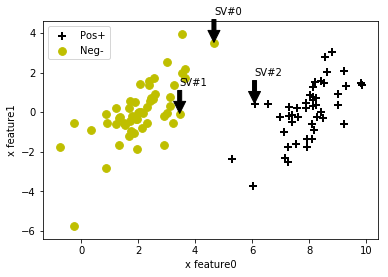

In [7]:
X=np.mat(X_train)
y=np.mat(y_train).transpose()
neg = np.where(y==-1)
pos = np.where(y==1)
neg=neg[0]
pos=pos[0]
#rint(neg.shape)
#rint(neg)
axes = plt.gca()
X_neg=np.zeros([neg.shape[0],2],np.float32)
X_pos=np.zeros([pos.shape[0],2],np.float32)
for i in range(neg.shape[0]):
    X_neg[i]=X[neg[i]]
for i in range(pos.shape[0]):
    X_pos[i]=X[pos[i]]
    
axes.scatter(X_pos[:,0], X_pos[:,1], marker='+', c='k', s=60, linewidth=2, label="Pos+")
axes.scatter(X_neg[:,0], X_neg[:,1], c='y', s=60, label="Neg-")
axes.set_xlabel("x feature0")
axes.set_ylabel("x feature1")
axes.legend(frameon= True, fancybox = True);

idx=0
for i in XS:
    plt.annotate(
    # Label and coordinate
    'SV#%d'%idx, xy=(X[i,0],X[i,1]), xytext=(X[i,0],X[i,1]+1.414),
    # Custom arrow
    arrowprops=dict(facecolor='black', shrink=0.02))
    idx+=1


### Platt SMO

1. 提供辅助函数选择使Ei-Ej变化最大的j.


$$f(X_k)=(\alpha*y)^T*(XX_k^T)+b$$
$$E_k=f(X_k)-y_k$$

2. 注意一个np.multiply函数

**numpy定义的乘法区别**

```python
A=np.zeros([3,1],np.float32)
B=np.zeros([3,1],np.float32)
A[0]=1
A[1]=2
A[2]=3
B[0]=4
B[1]=5
B[2]=6
C=np.multiply(A,B)# 这个地方都是3x1的,按照矩阵乘法是不可以相乘的.但是这个numpy里边是用的对应位置相乘算的. 当我们的svm里边算fx时也会用到这个.注意这个和矩阵相乘的区别
print(C)
```

**如果是矩阵相乘**

我们本可以这样:
```python
A
B
A*B.T
```

In [8]:
A=np.zeros([3,1],np.float32)
B=np.zeros([3,1],np.float32)
A[0]=1
A[1]=2
A[2]=3
B[0]=4
B[1]=5
B[2]=6
C=np.multiply(A,B)
print(C)

[[  4.]
 [ 10.]
 [ 18.]]


In [16]:
class optStruc:
    # 类的初始化. 
    def __init__(self,dataMatIn,classLabels,C,toler):
        self.X=dataMatIn
        self.y=classLabels.transpose()
        self.C=C
        self.tor=toler
        self.m=dataMatIn.shape[0]
        self.alphas=np.mat(np.zeros((self.m,1),np.float32))
        self.b=0.0#np.mat(np.zeros((self.m,1),np.float32))
        self.eCache=np.mat(np.zeros((self.m,2),np.float32)) # 这里是2列的意思是,第0列是为了标记非边界的j的集合.第1列是对应的Ei-Ej
    
    # 计算第k个alpha和oS的差
def calcEk(oS,k): # 这个oS是self类型的.
    ##print("calcEk the k=%s",k)
    ##print("oS.alphas shape:",oS.alphas.shape)
    ##print("oS.y shape:",oS.y.shape)
    ##print("oS.X shape:",oS.X.shape)
    ##print("oS.X[k,:].T shape:",oS.X[k,:].T.shape)
    #A=np.multiply(oS.alphas,oS.y).T
    #print("np.multiply(oS.alphas,oS.y).T shape:",A.shape)
    #print("np.multiply(oS.alphas,oS.y).T",A)
    #B=(oS.X*oS.X[k,:].T)
    #print("(oS.X*oS.X[k,:].T) shape",B.shape)
    #print("(oS.X*oS.X[k,:].T)=",B)
    #C=A*B
    #print("np.multiply(oS.alphas,oS.y).T*(oS.X*oS.X[k,:].T) ",C)
    #print("oS.b",oS.b)
    fXk=float(np.multiply(oS.alphas,oS.y).T*(oS.X*oS.X[k,:].T))+oS.b  
    #fXk=C+oS.b
    #print("FXk with np.multiply(oS.alphas,oS.y).T*(oS.X*oS.X[k,:].T) ",fXk)
    Ek=fXk-float(oS.y[k])
    #print("alphas", oS.alphas)
    #print("y", oS.y)
    #print("X", oS.X)
    #print("Ek=%s,fXk=%s"%(Ek,fXk))
    return Ek

# 对于外循环i来说,找到内循环的j
# 两种方法:
# 1. 第一次初始化的时候alphas都是0,都在边界上.
#    此时从(1,m)中随机一个非i的值作为j
# 2. 之后选择alphas中不再边界上的非i的alpha.
#    依次计算所有的alpha的E和Ei的差.
#    找最大的差的那个alpha,作为j
def selectJ(i,oS,Ei):
    maxDeltaE=0
    Ej=0
    j=-1 # [ERORO OCCUS ] 做好初始化.
    oS.eCache[i]=[1,Ei]                # 把当前这个alphas[i]标记成非边界的. 并保存其对应的Ei.这个Ei是由上面的calcEk计算而来的.
    validEcacheList=np.nonzero(oS.eCache[:,0].A)[0]
    #print("SelectJ with i:%s, Ei:%s" %(i,Ei))
    #print("validEcacheList:%s"%validEcacheList)
    #print("len(validEcacheList):%s"%len(validEcacheList))
    if len(validEcacheList)>1:
        # 找到最大的Ei－Ej
        for k in validEcacheList:
            #print("validEcacheList's k=%s",k)
            if k==i: # 处理相等条件
                #print("k==i==%s",k)
                continue
            Ek=calcEk(oS,k)           #  oS.eCache[k,1] 此时还没有计算出来呢，不能直接取．
            deltaE=np.abs(Ei-Ek)      #  注意此处需要做abs
            if maxDeltaE<deltaE:
                maxDeltaE=deltaE
                j=k
                Ej=Ek
        #print("j:%s,Ej%s"%(j,Ej))
        return j,Ej
    else:
        j=selectJrand(i,oS.m)
        #print("j:%s,Ej%s"%(j,Ej))
        Ej=calcEk(oS,j)
    return j,Ej

def updateEk(oS,k):
    Ek=calcEk(oS,k)
    oS.eCache[k]=[1,k]
        

In [10]:
X=np.mat(X_train)
y=np.mat(y_train).transpose()
oS=optStruc(X,y.transpose(),0.6,0.001)
oS.alphas[1]=0.06961952
calcEk(oS,3)


0.5562768421679213

In [14]:
# 计算内循环
# 考察不满足KKT条件的alphas.
# 更新eta
# 更新L和H
# 及时判断中途的退出点
# 如果不退出了,就计算alphas[i]和alphas[j]的更新
#     同时要更新Ei和Ej到缓存eCache中.
def innerL(i,oS):
    
    DEBUG_SVM=False
    if DEBUG_SVM == True:
        print(oS.X.shape)
        print(oS.y.shape)
        print((np.multiply(oS.alphas,oS.y).T).shape)
    # step1. 选择j
    Ei=calcEk(oS,i)
    j,Ej=selectJ(i,oS,Ei)
       
    # step2. 判断是否满足KKT条件
    if (Ei*oS.y[i]<(-oS.tor)and (alphas[i]<oS.C)or (Ei*oS.y[i]>oS.tor) and (alphas[i]>0)):
        alpha_i_old=alphas[i].copy()
        alpha_j_old=alphas[j].copy()
        if oS.y[i]!=oS.y[j]:
            L=max(0, oS.alphas[j] - oS.alphas[i])
            H=min(oS.C,oS.alphas[j]-oS.alphas[i]+oS.C)
        else:
            L=max(0, oS.alphas[j] + oS.alphas[i]-oS.C)
            H=min(oS.C,oS.alphas[i]+oS.alphas[j])
        if L==H:
            print("L==H")
            return 0
        eta=2.0*oS.X[i,:]*oS.X[j,:].T-X[i,:]*oS.X[i,:].T-X[j,:]*oS.X[j,:].T
        if eta>=0:
            print("eta >=0")
            return 0
        oS.alphas[j]-=oS.y[j]*(Ei-Ej)/eta
        oS.alphas[j]=clipAlpha(oS.alphas[j],H,L)
        updateEk(oS,j)
        if (np.abs(oS.alphas[j]-alpha_j_old)<0.001):
            print("j not moving enough")
            return 0
        oS.alphas[i]+=oS.y[i]*oS.y[j]*(alpha_j_old-oS.alphas[j])
        updateEk(oS,i)
        
        
        ''' 仔细观察这两个区别,你丢掉了oS.x[i,:]
        b1 = oS.b - Ei- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:] - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:] - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.X[j,:]*oS.X[j,:].T
        '''
        b1 = oS.b - Ei- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:]*oS.X[i,:].T - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.X[i,:]*oS.X[j,:].T
        b2 = oS.b - Ej- oS.y[i]*(oS.alphas[i]-alpha_i_old)*oS.X[i,:]*oS.X[i,:].T - oS.y[j]*(oS.alphas[j]-alpha_j_old)*oS.X[j,:]*oS.X[j,:].T
        #print("b1",b1)
        #print("b2",b2)
        if (0<alphas[i])and (alphas[i]<oS.C):
            oS.b=b1
        elif (0<alphas[j])and (alphas[j]<oS.C):
            oS.b=b2
        else:
            oS.b=(b1+b2)/2.0
        return 1
    else:
        return 0
    
            

In [17]:
def smoPlatt(X,y,C,toler,maxIter):
    oS=optStruc(X,y.transpose(),C,toler)
    iteritem=0
    entireSet=True
    alphasChanged=0
    
    DEBUG_SVM=True
    if DEBUG_SVM == True:
        print(X.shape)
        print(y.shape)
        
    while (iteritem<maxIter) and ( (alphasChanged>0)or (entireSet)):
        alphasChanged=0
        if entireSet: # 第一次进来,肯定遍历所有的item的.
            for i in range(oS.m):
                alphasChanged+=innerL(i,oS)
                print("fullSet, iter: %d i:%d, pairs changed %d" % (iteritem,i,alphasChanged))
            iteritem+=1
        else: # 仅仅对非边界的alphas做调整.
            #选出既不等于0,也不等于C的alphas
            nonBoundries=np.nonzero((alphas.A>0)*(alphas.A<C))[0]
            for i in nonBoundries:
                alphasChanged+=innerL(i,oS)
                print("non-Boundries, iter: %d i:%d, pairs changed %d" % (iteritem,i,alphasChanged))
            iteritem+=1
        if entireSet:
            entireSet=False
        
        if alphasChanged==0: # 如果内循环没有满足的alpha,此时重新进入遍历. 与simple smo不同的是,simple smo会清零iteritem,导致多次遍历.我们这边仅仅把entirSet标志置位.
            entireSet=True
        print("iteration num :%d",iter)
        
    return oS.b,oS.alphas

X=np.mat(X_train)
y=np.mat(y_train).transpose()
b,alphas=smoPlatt(X,y,0.6,0.001,40)

(100, 2)
(100, 1)
fullSet, iter: 0 i:0, pairs changed 1
fullSet, iter: 0 i:1, pairs changed 1
fullSet, iter: 0 i:2, pairs changed 2
fullSet, iter: 0 i:3, pairs changed 3
fullSet, iter: 0 i:4, pairs changed 4
fullSet, iter: 0 i:5, pairs changed 5
fullSet, iter: 0 i:6, pairs changed 6
fullSet, iter: 0 i:7, pairs changed 7
fullSet, iter: 0 i:8, pairs changed 8
fullSet, iter: 0 i:9, pairs changed 8
L==H
fullSet, iter: 0 i:10, pairs changed 8
fullSet, iter: 0 i:11, pairs changed 9
fullSet, iter: 0 i:12, pairs changed 10
fullSet, iter: 0 i:13, pairs changed 10
fullSet, iter: 0 i:14, pairs changed 11
fullSet, iter: 0 i:15, pairs changed 11
j not moving enough
fullSet, iter: 0 i:16, pairs changed 11
L==H
fullSet, iter: 0 i:17, pairs changed 11
fullSet, iter: 0 i:18, pairs changed 11
fullSet, iter: 0 i:19, pairs changed 11
fullSet, iter: 0 i:20, pairs changed 11
fullSet, iter: 0 i:21, pairs changed 12
fullSet, iter: 0 i:22, pairs changed 12
L==H
fullSet, iter: 0 i:23, pairs changed 12
L==H
full

fullSet, iter: 3 i:55, pairs changed 0
fullSet, iter: 3 i:56, pairs changed 0
fullSet, iter: 3 i:57, pairs changed 0
fullSet, iter: 3 i:58, pairs changed 0
fullSet, iter: 3 i:59, pairs changed 0
fullSet, iter: 3 i:60, pairs changed 0
fullSet, iter: 3 i:61, pairs changed 0
fullSet, iter: 3 i:62, pairs changed 0
fullSet, iter: 3 i:63, pairs changed 0
fullSet, iter: 3 i:64, pairs changed 0
fullSet, iter: 3 i:65, pairs changed 0
fullSet, iter: 3 i:66, pairs changed 0
fullSet, iter: 3 i:67, pairs changed 0
fullSet, iter: 3 i:68, pairs changed 0
fullSet, iter: 3 i:69, pairs changed 0
fullSet, iter: 3 i:70, pairs changed 0
fullSet, iter: 3 i:71, pairs changed 0
fullSet, iter: 3 i:72, pairs changed 0
fullSet, iter: 3 i:73, pairs changed 0
fullSet, iter: 3 i:74, pairs changed 0
fullSet, iter: 3 i:75, pairs changed 0
fullSet, iter: 3 i:76, pairs changed 0
fullSet, iter: 3 i:77, pairs changed 0
fullSet, iter: 3 i:78, pairs changed 0
fullSet, iter: 3 i:79, pairs changed 0
fullSet, iter: 3 i:80, pa

fullSet, iter: 5 i:63, pairs changed 0
fullSet, iter: 5 i:64, pairs changed 0
fullSet, iter: 5 i:65, pairs changed 0
fullSet, iter: 5 i:66, pairs changed 0
fullSet, iter: 5 i:67, pairs changed 0
fullSet, iter: 5 i:68, pairs changed 0
fullSet, iter: 5 i:69, pairs changed 0
fullSet, iter: 5 i:70, pairs changed 0
fullSet, iter: 5 i:71, pairs changed 0
fullSet, iter: 5 i:72, pairs changed 0
fullSet, iter: 5 i:73, pairs changed 0
fullSet, iter: 5 i:74, pairs changed 0
fullSet, iter: 5 i:75, pairs changed 0
fullSet, iter: 5 i:76, pairs changed 0
fullSet, iter: 5 i:77, pairs changed 0
fullSet, iter: 5 i:78, pairs changed 0
fullSet, iter: 5 i:79, pairs changed 0
fullSet, iter: 5 i:80, pairs changed 0
fullSet, iter: 5 i:81, pairs changed 0
fullSet, iter: 5 i:82, pairs changed 0
fullSet, iter: 5 i:83, pairs changed 0
fullSet, iter: 5 i:84, pairs changed 0
fullSet, iter: 5 i:85, pairs changed 0
fullSet, iter: 5 i:86, pairs changed 0
fullSet, iter: 5 i:87, pairs changed 0
fullSet, iter: 5 i:88, pa

fullSet, iter: 7 i:73, pairs changed 0
fullSet, iter: 7 i:74, pairs changed 0
fullSet, iter: 7 i:75, pairs changed 0
fullSet, iter: 7 i:76, pairs changed 0
fullSet, iter: 7 i:77, pairs changed 0
fullSet, iter: 7 i:78, pairs changed 0
fullSet, iter: 7 i:79, pairs changed 0
fullSet, iter: 7 i:80, pairs changed 0
fullSet, iter: 7 i:81, pairs changed 0
fullSet, iter: 7 i:82, pairs changed 0
fullSet, iter: 7 i:83, pairs changed 0
fullSet, iter: 7 i:84, pairs changed 0
fullSet, iter: 7 i:85, pairs changed 0
fullSet, iter: 7 i:86, pairs changed 0
fullSet, iter: 7 i:87, pairs changed 0
fullSet, iter: 7 i:88, pairs changed 0
fullSet, iter: 7 i:89, pairs changed 0
fullSet, iter: 7 i:90, pairs changed 0
fullSet, iter: 7 i:91, pairs changed 0
fullSet, iter: 7 i:92, pairs changed 0
fullSet, iter: 7 i:93, pairs changed 0
fullSet, iter: 7 i:94, pairs changed 0
fullSet, iter: 7 i:95, pairs changed 0
fullSet, iter: 7 i:96, pairs changed 0
fullSet, iter: 7 i:97, pairs changed 0
fullSet, iter: 7 i:98, pa

fullSet, iter: 9 i:86, pairs changed 0
fullSet, iter: 9 i:87, pairs changed 0
fullSet, iter: 9 i:88, pairs changed 0
fullSet, iter: 9 i:89, pairs changed 0
fullSet, iter: 9 i:90, pairs changed 0
fullSet, iter: 9 i:91, pairs changed 0
fullSet, iter: 9 i:92, pairs changed 0
fullSet, iter: 9 i:93, pairs changed 0
fullSet, iter: 9 i:94, pairs changed 0
fullSet, iter: 9 i:95, pairs changed 0
fullSet, iter: 9 i:96, pairs changed 0
fullSet, iter: 9 i:97, pairs changed 0
fullSet, iter: 9 i:98, pairs changed 0
fullSet, iter: 9 i:99, pairs changed 0
iteration num :%d <built-in function iter>
j not moving enough
fullSet, iter: 10 i:0, pairs changed 0
fullSet, iter: 10 i:1, pairs changed 0
fullSet, iter: 10 i:2, pairs changed 0
j not moving enough
fullSet, iter: 10 i:3, pairs changed 0
j not moving enough
fullSet, iter: 10 i:4, pairs changed 0
j not moving enough
fullSet, iter: 10 i:5, pairs changed 0
j not moving enough
fullSet, iter: 10 i:6, pairs changed 0
fullSet, iter: 10 i:7, pairs changed 0

j not moving enough
fullSet, iter: 12 i:14, pairs changed 0
fullSet, iter: 12 i:15, pairs changed 0
j not moving enough
fullSet, iter: 12 i:16, pairs changed 0
L==H
fullSet, iter: 12 i:17, pairs changed 0
fullSet, iter: 12 i:18, pairs changed 0
fullSet, iter: 12 i:19, pairs changed 0
fullSet, iter: 12 i:20, pairs changed 0
j not moving enough
fullSet, iter: 12 i:21, pairs changed 0
fullSet, iter: 12 i:22, pairs changed 0
fullSet, iter: 12 i:23, pairs changed 0
fullSet, iter: 12 i:24, pairs changed 0
fullSet, iter: 12 i:25, pairs changed 0
fullSet, iter: 12 i:26, pairs changed 0
fullSet, iter: 12 i:27, pairs changed 0
fullSet, iter: 12 i:28, pairs changed 0
fullSet, iter: 12 i:29, pairs changed 0
fullSet, iter: 12 i:30, pairs changed 0
fullSet, iter: 12 i:31, pairs changed 0
fullSet, iter: 12 i:32, pairs changed 0
fullSet, iter: 12 i:33, pairs changed 0
fullSet, iter: 12 i:34, pairs changed 0
fullSet, iter: 12 i:35, pairs changed 0
fullSet, iter: 12 i:36, pairs changed 0
fullSet, iter: 

j not moving enough
fullSet, iter: 14 i:14, pairs changed 0
fullSet, iter: 14 i:15, pairs changed 0
j not moving enough
fullSet, iter: 14 i:16, pairs changed 0
L==H
fullSet, iter: 14 i:17, pairs changed 0
fullSet, iter: 14 i:18, pairs changed 0
fullSet, iter: 14 i:19, pairs changed 0
fullSet, iter: 14 i:20, pairs changed 0
j not moving enough
fullSet, iter: 14 i:21, pairs changed 0
fullSet, iter: 14 i:22, pairs changed 0
fullSet, iter: 14 i:23, pairs changed 0
fullSet, iter: 14 i:24, pairs changed 0
fullSet, iter: 14 i:25, pairs changed 0
fullSet, iter: 14 i:26, pairs changed 0
fullSet, iter: 14 i:27, pairs changed 0
fullSet, iter: 14 i:28, pairs changed 0
fullSet, iter: 14 i:29, pairs changed 0
fullSet, iter: 14 i:30, pairs changed 0
fullSet, iter: 14 i:31, pairs changed 0
fullSet, iter: 14 i:32, pairs changed 0
fullSet, iter: 14 i:33, pairs changed 0
fullSet, iter: 14 i:34, pairs changed 0
fullSet, iter: 14 i:35, pairs changed 0
fullSet, iter: 14 i:36, pairs changed 0
fullSet, iter: 

fullSet, iter: 16 i:55, pairs changed 0
fullSet, iter: 16 i:56, pairs changed 0
fullSet, iter: 16 i:57, pairs changed 0
fullSet, iter: 16 i:58, pairs changed 0
fullSet, iter: 16 i:59, pairs changed 0
fullSet, iter: 16 i:60, pairs changed 0
fullSet, iter: 16 i:61, pairs changed 0
fullSet, iter: 16 i:62, pairs changed 0
fullSet, iter: 16 i:63, pairs changed 0
fullSet, iter: 16 i:64, pairs changed 0
fullSet, iter: 16 i:65, pairs changed 0
fullSet, iter: 16 i:66, pairs changed 0
fullSet, iter: 16 i:67, pairs changed 0
fullSet, iter: 16 i:68, pairs changed 0
fullSet, iter: 16 i:69, pairs changed 0
fullSet, iter: 16 i:70, pairs changed 0
fullSet, iter: 16 i:71, pairs changed 0
fullSet, iter: 16 i:72, pairs changed 0
fullSet, iter: 16 i:73, pairs changed 0
fullSet, iter: 16 i:74, pairs changed 0
fullSet, iter: 16 i:75, pairs changed 0
fullSet, iter: 16 i:76, pairs changed 0
fullSet, iter: 16 i:77, pairs changed 0
fullSet, iter: 16 i:78, pairs changed 0
fullSet, iter: 16 i:79, pairs changed 0


fullSet, iter: 18 i:84, pairs changed 0
fullSet, iter: 18 i:85, pairs changed 0
fullSet, iter: 18 i:86, pairs changed 0
fullSet, iter: 18 i:87, pairs changed 0
fullSet, iter: 18 i:88, pairs changed 0
fullSet, iter: 18 i:89, pairs changed 0
fullSet, iter: 18 i:90, pairs changed 0
fullSet, iter: 18 i:91, pairs changed 0
fullSet, iter: 18 i:92, pairs changed 0
fullSet, iter: 18 i:93, pairs changed 0
fullSet, iter: 18 i:94, pairs changed 0
fullSet, iter: 18 i:95, pairs changed 0
fullSet, iter: 18 i:96, pairs changed 0
fullSet, iter: 18 i:97, pairs changed 0
fullSet, iter: 18 i:98, pairs changed 0
fullSet, iter: 18 i:99, pairs changed 0
iteration num :%d <built-in function iter>
j not moving enough
fullSet, iter: 19 i:0, pairs changed 0
fullSet, iter: 19 i:1, pairs changed 0
fullSet, iter: 19 i:2, pairs changed 0
j not moving enough
fullSet, iter: 19 i:3, pairs changed 0
j not moving enough
fullSet, iter: 19 i:4, pairs changed 0
j not moving enough
fullSet, iter: 19 i:5, pairs changed 0
j n

fullSet, iter: 21 i:48, pairs changed 0
fullSet, iter: 21 i:49, pairs changed 0
fullSet, iter: 21 i:50, pairs changed 0
fullSet, iter: 21 i:51, pairs changed 0
fullSet, iter: 21 i:52, pairs changed 0
fullSet, iter: 21 i:53, pairs changed 0
fullSet, iter: 21 i:54, pairs changed 0
fullSet, iter: 21 i:55, pairs changed 0
fullSet, iter: 21 i:56, pairs changed 0
fullSet, iter: 21 i:57, pairs changed 0
fullSet, iter: 21 i:58, pairs changed 0
fullSet, iter: 21 i:59, pairs changed 0
fullSet, iter: 21 i:60, pairs changed 0
fullSet, iter: 21 i:61, pairs changed 0
fullSet, iter: 21 i:62, pairs changed 0
fullSet, iter: 21 i:63, pairs changed 0
fullSet, iter: 21 i:64, pairs changed 0
fullSet, iter: 21 i:65, pairs changed 0
fullSet, iter: 21 i:66, pairs changed 0
fullSet, iter: 21 i:67, pairs changed 0
fullSet, iter: 21 i:68, pairs changed 0
fullSet, iter: 21 i:69, pairs changed 0
fullSet, iter: 21 i:70, pairs changed 0
fullSet, iter: 21 i:71, pairs changed 0
fullSet, iter: 21 i:72, pairs changed 0


j not moving enough
fullSet, iter: 24 i:6, pairs changed 0
fullSet, iter: 24 i:7, pairs changed 0
fullSet, iter: 24 i:8, pairs changed 0
fullSet, iter: 24 i:9, pairs changed 0
fullSet, iter: 24 i:10, pairs changed 0
fullSet, iter: 24 i:11, pairs changed 0
j not moving enough
fullSet, iter: 24 i:12, pairs changed 0
fullSet, iter: 24 i:13, pairs changed 0
j not moving enough
fullSet, iter: 24 i:14, pairs changed 0
fullSet, iter: 24 i:15, pairs changed 0
j not moving enough
fullSet, iter: 24 i:16, pairs changed 0
L==H
fullSet, iter: 24 i:17, pairs changed 0
fullSet, iter: 24 i:18, pairs changed 0
fullSet, iter: 24 i:19, pairs changed 0
fullSet, iter: 24 i:20, pairs changed 0
j not moving enough
fullSet, iter: 24 i:21, pairs changed 0
fullSet, iter: 24 i:22, pairs changed 0
fullSet, iter: 24 i:23, pairs changed 0
fullSet, iter: 24 i:24, pairs changed 0
fullSet, iter: 24 i:25, pairs changed 0
fullSet, iter: 24 i:26, pairs changed 0
fullSet, iter: 24 i:27, pairs changed 0
fullSet, iter: 24 i

fullSet, iter: 26 i:58, pairs changed 0
fullSet, iter: 26 i:59, pairs changed 0
fullSet, iter: 26 i:60, pairs changed 0
fullSet, iter: 26 i:61, pairs changed 0
fullSet, iter: 26 i:62, pairs changed 0
fullSet, iter: 26 i:63, pairs changed 0
fullSet, iter: 26 i:64, pairs changed 0
fullSet, iter: 26 i:65, pairs changed 0
fullSet, iter: 26 i:66, pairs changed 0
fullSet, iter: 26 i:67, pairs changed 0
fullSet, iter: 26 i:68, pairs changed 0
fullSet, iter: 26 i:69, pairs changed 0
fullSet, iter: 26 i:70, pairs changed 0
fullSet, iter: 26 i:71, pairs changed 0
fullSet, iter: 26 i:72, pairs changed 0
fullSet, iter: 26 i:73, pairs changed 0
fullSet, iter: 26 i:74, pairs changed 0
fullSet, iter: 26 i:75, pairs changed 0
fullSet, iter: 26 i:76, pairs changed 0
fullSet, iter: 26 i:77, pairs changed 0
fullSet, iter: 26 i:78, pairs changed 0
fullSet, iter: 26 i:79, pairs changed 0
fullSet, iter: 26 i:80, pairs changed 0
fullSet, iter: 26 i:81, pairs changed 0
fullSet, iter: 26 i:82, pairs changed 0


fullSet, iter: 29 i:13, pairs changed 0
j not moving enough
fullSet, iter: 29 i:14, pairs changed 0
fullSet, iter: 29 i:15, pairs changed 0
j not moving enough
fullSet, iter: 29 i:16, pairs changed 0
L==H
fullSet, iter: 29 i:17, pairs changed 0
fullSet, iter: 29 i:18, pairs changed 0
fullSet, iter: 29 i:19, pairs changed 0
fullSet, iter: 29 i:20, pairs changed 0
j not moving enough
fullSet, iter: 29 i:21, pairs changed 0
fullSet, iter: 29 i:22, pairs changed 0
fullSet, iter: 29 i:23, pairs changed 0
fullSet, iter: 29 i:24, pairs changed 0
fullSet, iter: 29 i:25, pairs changed 0
fullSet, iter: 29 i:26, pairs changed 0
fullSet, iter: 29 i:27, pairs changed 0
fullSet, iter: 29 i:28, pairs changed 0
fullSet, iter: 29 i:29, pairs changed 0
fullSet, iter: 29 i:30, pairs changed 0
fullSet, iter: 29 i:31, pairs changed 0
fullSet, iter: 29 i:32, pairs changed 0
fullSet, iter: 29 i:33, pairs changed 0
fullSet, iter: 29 i:34, pairs changed 0
fullSet, iter: 29 i:35, pairs changed 0
fullSet, iter: 

fullSet, iter: 31 i:56, pairs changed 0
fullSet, iter: 31 i:57, pairs changed 0
fullSet, iter: 31 i:58, pairs changed 0
fullSet, iter: 31 i:59, pairs changed 0
fullSet, iter: 31 i:60, pairs changed 0
fullSet, iter: 31 i:61, pairs changed 0
fullSet, iter: 31 i:62, pairs changed 0
fullSet, iter: 31 i:63, pairs changed 0
fullSet, iter: 31 i:64, pairs changed 0
fullSet, iter: 31 i:65, pairs changed 0
fullSet, iter: 31 i:66, pairs changed 0
fullSet, iter: 31 i:67, pairs changed 0
fullSet, iter: 31 i:68, pairs changed 0
fullSet, iter: 31 i:69, pairs changed 0
fullSet, iter: 31 i:70, pairs changed 0
fullSet, iter: 31 i:71, pairs changed 0
fullSet, iter: 31 i:72, pairs changed 0
fullSet, iter: 31 i:73, pairs changed 0
fullSet, iter: 31 i:74, pairs changed 0
fullSet, iter: 31 i:75, pairs changed 0
fullSet, iter: 31 i:76, pairs changed 0
fullSet, iter: 31 i:77, pairs changed 0
fullSet, iter: 31 i:78, pairs changed 0
fullSet, iter: 31 i:79, pairs changed 0
fullSet, iter: 31 i:80, pairs changed 0


fullSet, iter: 33 i:50, pairs changed 0
fullSet, iter: 33 i:51, pairs changed 0
fullSet, iter: 33 i:52, pairs changed 0
fullSet, iter: 33 i:53, pairs changed 0
fullSet, iter: 33 i:54, pairs changed 0
fullSet, iter: 33 i:55, pairs changed 0
fullSet, iter: 33 i:56, pairs changed 0
fullSet, iter: 33 i:57, pairs changed 0
fullSet, iter: 33 i:58, pairs changed 0
fullSet, iter: 33 i:59, pairs changed 0
fullSet, iter: 33 i:60, pairs changed 0
fullSet, iter: 33 i:61, pairs changed 0
fullSet, iter: 33 i:62, pairs changed 0
fullSet, iter: 33 i:63, pairs changed 0
fullSet, iter: 33 i:64, pairs changed 0
fullSet, iter: 33 i:65, pairs changed 0
fullSet, iter: 33 i:66, pairs changed 0
fullSet, iter: 33 i:67, pairs changed 0
fullSet, iter: 33 i:68, pairs changed 0
fullSet, iter: 33 i:69, pairs changed 0
fullSet, iter: 33 i:70, pairs changed 0
fullSet, iter: 33 i:71, pairs changed 0
fullSet, iter: 33 i:72, pairs changed 0
fullSet, iter: 33 i:73, pairs changed 0
fullSet, iter: 33 i:74, pairs changed 0


fullSet, iter: 35 i:96, pairs changed 0
fullSet, iter: 35 i:97, pairs changed 0
fullSet, iter: 35 i:98, pairs changed 0
fullSet, iter: 35 i:99, pairs changed 0
iteration num :%d <built-in function iter>
j not moving enough
fullSet, iter: 36 i:0, pairs changed 0
fullSet, iter: 36 i:1, pairs changed 0
fullSet, iter: 36 i:2, pairs changed 0
j not moving enough
fullSet, iter: 36 i:3, pairs changed 0
j not moving enough
fullSet, iter: 36 i:4, pairs changed 0
j not moving enough
fullSet, iter: 36 i:5, pairs changed 0
j not moving enough
fullSet, iter: 36 i:6, pairs changed 0
fullSet, iter: 36 i:7, pairs changed 0
fullSet, iter: 36 i:8, pairs changed 0
fullSet, iter: 36 i:9, pairs changed 0
fullSet, iter: 36 i:10, pairs changed 0
fullSet, iter: 36 i:11, pairs changed 0
j not moving enough
fullSet, iter: 36 i:12, pairs changed 0
fullSet, iter: 36 i:13, pairs changed 0
j not moving enough
fullSet, iter: 36 i:14, pairs changed 0
fullSet, iter: 36 i:15, pairs changed 0
j not moving enough
fullSet

fullSet, iter: 38 i:81, pairs changed 0
fullSet, iter: 38 i:82, pairs changed 0
fullSet, iter: 38 i:83, pairs changed 0
fullSet, iter: 38 i:84, pairs changed 0
fullSet, iter: 38 i:85, pairs changed 0
fullSet, iter: 38 i:86, pairs changed 0
fullSet, iter: 38 i:87, pairs changed 0
fullSet, iter: 38 i:88, pairs changed 0
fullSet, iter: 38 i:89, pairs changed 0
fullSet, iter: 38 i:90, pairs changed 0
fullSet, iter: 38 i:91, pairs changed 0
fullSet, iter: 38 i:92, pairs changed 0
fullSet, iter: 38 i:93, pairs changed 0
fullSet, iter: 38 i:94, pairs changed 0
fullSet, iter: 38 i:95, pairs changed 0
fullSet, iter: 38 i:96, pairs changed 0
fullSet, iter: 38 i:97, pairs changed 0
fullSet, iter: 38 i:98, pairs changed 0
fullSet, iter: 38 i:99, pairs changed 0
iteration num :%d <built-in function iter>
j not moving enough
fullSet, iter: 39 i:0, pairs changed 0
fullSet, iter: 39 i:1, pairs changed 0
fullSet, iter: 39 i:2, pairs changed 0
j not moving enough
fullSet, iter: 39 i:3, pairs changed 0
j

In [19]:
print(alphas)

[[ 0.09152041]
 [ 0.        ]
 [ 0.03527183]
 [ 0.06435952]
 [ 0.        ]
 [ 0.0598441 ]
 [ 0.07088107]
 [-0.00732936]
 [ 0.03075641]
 [ 0.        ]
 [ 0.        ]
 [-0.00732936]
 [ 0.        ]
 [ 0.        ]
 [ 0.00732936]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.07665125]
 [ 0.        ]
 [ 0.        ]
 [ 0.01465872]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.06760281]
 [ 0.        ]
 [ 0.        ]
 [-0.06760281]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.     